In [1]:
import torch
import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from dataset import *
from network import *

/tmp/ipykernel_3403939/2508751479.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/home/liruixin/workspace/gas/gas_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:3
<class 'rockpool.nn.modules.sinabs.lif_exodus.LIFExodus'>


/home/liruixin/workspace/gas/gas_env/lib/python3.8/site-packages/rockpool/nn/networks/__init__.py:15: UserWarning: This module needs to be ported to teh v2 API.
  warnings.warn(f"{err}")
/home/liruixin/workspace/gas/gas_env/lib/python3.8/site-packages/rockpool/nn/networks/__init__.py:20: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")


In [2]:
synnet = synnet_fspike
model = synnet.to(device)

In [3]:
def generate_data(path):
    file = Path(path)
    file_list = list(file.rglob('*.csv'))
    # random.shuffle(file_list)
    data_list = []
    label_list = []
    for file in tqdm(file_list):
        raw = pd.read_csv(str(file))
        data = (raw.iloc[:,1:4]).values
        split_arrays = split_array(data, chunk_size=5000)
        # 0:jog, 1:walk
        label = 0 if file.parts[-4][0] == 'j' else 1
        data_list.extend(split_arrays)
        label_list = label_list + [label]*len(split_arrays)
    return data_list, label_list 
triggle = input('请问您是否存储了dataset(y/n):')
if triggle == 'n':
    data_list, label_list = generate_data(path='/home/liruixin/workspace/imu_classification/data')
    combined = list(zip(data_list, label_list))
    random.shuffle(combined)
    data_list, label_list = zip(*combined)
    train_dataset = IMU_dataset(data_list, label_list)
    

    with open(f'/home/liruixin/workspace/imu_classification/dataset_file/train_dataset_whole_data.pkl', 'wb') as file:
        pickle.dump(train_dataset, file)

if triggle == 'y':
    with open(f'/home/liruixin/workspace/imu_classification/dataset_file/train_dataset_whole_data.pkl', 'rb') as file:
        train_dataset = pickle.load(file)
train_dataloader  = DataLoader(train_dataset,batch_size=1)

In [4]:
train_dataset[0][0].shape

torch.Size([5000, 15])

In [ ]:
train_preds = []
train_targets = []
for batch, target in tqdm(train_dataloader):
    with torch.no_grad():
        batch = batch.to(torch.float32).to(device)
        target = target.to(device)
        model.reset_state()
        out_model, _, rec = model(batch, record=True)
        colors = ['red', 'blue', 'green', 'purple', 'orange']
        data = rec['4_LIFExodus']['vmem']
        for i in range(2):                                           
            plt.plot((rec['4_LIFExodus']['vmem'].cpu().detach().numpy()).T[i,:], label=f"label{i}",color=colors[i])
        plt.legend()
        plt.title(target)
        plt.show()
        out = torch.sum(out_model,dim=1)
        pred = out.argmax(1).detach().to(device)
        train_preds += pred.detach().cpu().numpy().tolist()
        train_targets += target.detach().cpu().numpy().tolist()

train_accuracy = accuracy_score(train_targets, train_preds)
cm = confusion_matrix(train_targets, train_preds)
print(train_accuracy)
print(cm)


In [ ]:
no_spike_num = 0
for batch, target in tqdm(train_dataloader):
    with torch.no_grad():
        batch = batch.to(torch.float32).to(device)
        target = target.to(device)
        model.reset_state()
        out_model, _, rec = model(batch, record=True)
        colors = ['red', 'blue', 'green', 'purple', 'orange']
        data = rec['4_LIFExodus']['vmem']
        out, no_spike_num = detect_spike_analog(rec,7.0,no_spike_num)
        pred = out.argmax(1)
        # if  target.item() != pred[0]:
        #     print(target.item())
        #     print(pred[0])
        #     for i in range(2):                                           
        #         plt.plot((rec['4_LIFExodus']['vmem'].cpu().detach().numpy()).T[i,:], label=f"label{i}",color=colors[i])
        #     plt.legend()
        #     plt.title(target)
        #     plt.show()
        out = torch.sum(out_model,dim=1)
        train_preds += pred.tolist()
        train_targets += target.tolist()

train_accuracy = accuracy_score(train_targets, train_preds)
cm = confusion_matrix(train_targets, train_preds)
print(train_accuracy)
print(cm)


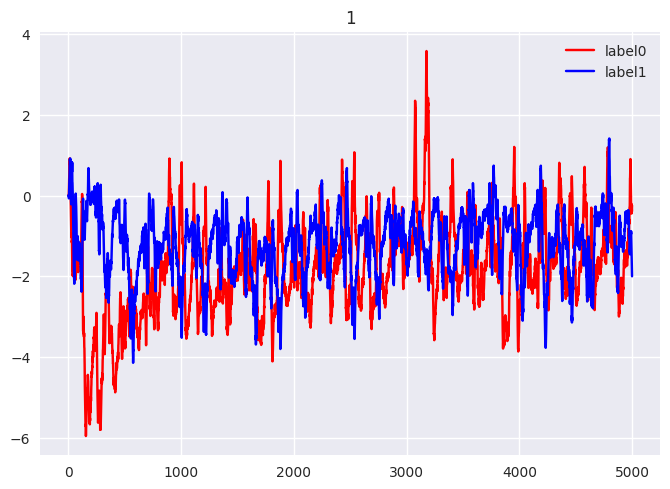

In [8]:
model.reset_state()
x = 60
out_model, _, rec = model(train_dataset[x][0].to(torch.float32).to(device), record=True)
colors = ['red', 'blue', 'green', 'purple', 'orange']
data = rec['4_LIFExodus']['vmem']
for i in range(2):                                           
    plt.plot((rec['4_LIFExodus']['vmem'].cpu().detach().numpy()).T[i,:], label=f"label{i}",color=colors[i])
plt.legend()
plt.title(train_dataset[x][1])
plt.show()

In [ ]:
rec['1_LIFExodus']['spikes'].sum()